In [2]:
import matplotlib.pyplot as plt  # plotting library
import numpy as np  # numerical library
import xarray as xr  # netCDF library
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list
import cftime
import pandas as pd

In [3]:
# Some defaults:
plt.rcParams['figure.figsize'] = (12, 5)  # Default plot size

In [4]:
#To compute de climatoloy
yearC1='2004'
yearC2='2014'

# Read data

In [5]:
data_dir='/Users/pvb/Dropbox/Oceanografia/Data/Climatologias/ISAS20_ARGO/NC/'

filesT = []
filesS = []
for iy in range(2002,2021):
    for im in range(1,13):
        filesT.append(data_dir+"%04d/"%(iy)+"ISAS20_ARGO_%04d%02d15_fld_TEMP.nc"%(iy,im))
        filesS.append(data_dir+"%04d/"%(iy)+"ISAS20_ARGO_%04d%02d15_fld_PSAL.nc"%(iy,im))

In [6]:
dataT = xr.open_mfdataset(filesT)
dataS = xr.open_mfdataset(filesS)

In [7]:
ISAS = dataT.drop_vars("TEMP_ERR").drop_vars("TEMP_PCTVAR").rename_vars(name_dict={'TEMP':'temperature'}).assign(salinity=dataS.PSAL)
ISAS = ISAS.rename_vars(name_dict={'longitude':'lon'}).rename_vars(name_dict={'latitude':'lat'})

In [8]:
ISAS =  ISAS.rename({'longitude': 'lon','latitude': 'lat'})

/var/folders/tj/cj2twzcd30jbzn574lsp6phw0000gn/T/ipykernel_67710/2539251185.py:1: UserWarning: rename 'longitude' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ISAS =  ISAS.rename({'longitude': 'lon','latitude': 'lat'})
/var/folders/tj/cj2twzcd30jbzn574lsp6phw0000gn/T/ipykernel_67710/2539251185.py:1: UserWarning: rename 'latitude' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ISAS =  ISAS.rename({'longitude': 'lon','latitude': 'lat'})


In [8]:
DC=ISAS

In [9]:
ISAS

<xarray.Dataset> Size: 268GB
Dimensions:      (lon: 720, lat: 545, depth: 187, time: 228)
Coordinates:
  * lon          (lon) float32 3kB -180.0 -179.5 -179.0 ... 178.5 179.0 179.5
  * lat          (lat) float32 2kB -77.01 -76.9 -76.78 ... 89.49 89.69 89.9
  * depth        (depth) float32 748B 1.0 3.0 5.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time         (time) datetime64[ns] 2kB 2002-01-15 2002-02-15 ... 2020-12-15
Data variables:
    temperature  (time, depth, lat, lon) float64 134GB dask.array<chunksize=(1, 187, 545, 720), meta=np.ndarray>
    salinity     (time, depth, lat, lon) float64 134GB dask.array<chunksize=(1, 187, 545, 720), meta=np.ndarray>
Attributes: (12/20)
    Conventions:            CF-1.4
    title:                  Monthly analysis
    history:                20210706T111131L : Creation
    institution:            LOPS/IFREMER/IUEM
    project_name:           ISASLOPS
    analysis_name:          ISAS20_ARGO_
    ...                     ...
    start_date:             2002-01-15
    stop_date:              2002-01-15
    creation_date:          20210706T111131L
    reference_date:         1950-01-01T00:00:00Z
    references:             Gaillard et al., JCLIM 2016, Doi:10.1175/JCLI-D-1...
    comment:                V8.0 T and S fields

## Data selection

In [11]:
DC_temp=ISAS.temperature.sel(lat=slice( -60, 60)).sel(depth=slice(0,2000))
DC_salt=ISAS.salinity.sel(lat=slice( -60, 60)).sel(depth=slice(0,2000))

## Seasonal cycle
Create seasonal climatology from 1982 to 1992 and the asociated anomaly

In [12]:
#Create monthly climatology
DC_temp_clim = DC_temp.sel(time=slice(yearC1,yearC2)).groupby('time.month').mean(dim='time');
DC_salt_clim = DC_salt.sel(time=slice(yearC1,yearC2)).groupby('time.month').mean(dim='time');

In [13]:
#Create anomaly
DC_temp_anom = DC_temp.groupby('time.month') - DC_temp_clim
DC_salt_anom = DC_salt.groupby('time.month') - DC_salt_clim

/Users/pvb/miniconda3/envs/ocean/lib/python3.11/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing with an out-of-order index is generating 19 times more chunks
  return self.array[key]
/Users/pvb/miniconda3/envs/ocean/lib/python3.11/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing with an out-of-order index is generating 19 times more chunks
  return self.array[key]


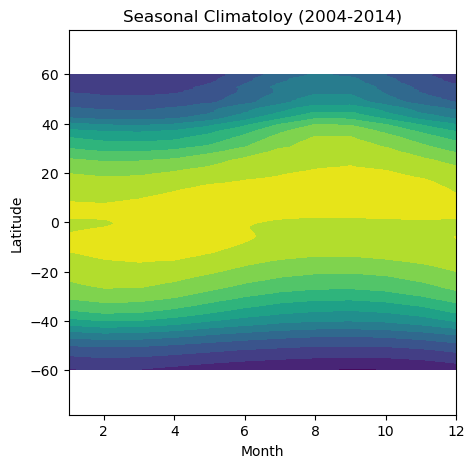

In [14]:
fig, ax = plt.subplots(1, 1 , figsize=(5,5))
ax.contourf(DC_temp_clim.mean(dim='lon').sel(depth=10,method="nearest").month,
                 DC_temp_clim.mean(dim='lon').sel(depth=10,method="nearest").lat,
                 DC_temp_clim.mean(dim='lon').sel(depth=10,method="nearest").transpose(),levels=12, vmin=-2, vmax=30)
ax.set_ylim(-78,78)
ax.grid()
ax.set_title('Seasonal Climatoloy (' + yearC1 + '-' + yearC2 + ')')
ax.set_ylabel('Latitude') 
ax.set_xlabel('Month')
ax.grid()

# Mean weighted

In [18]:
weights = np.cos(np.deg2rad(DC_temp.lat))
weights = weights/weights.max()
weights.name = "weights"
DC_temp_weighted = DC_temp.weighted(weights)
DC_salt_weighted = DC_salt.weighted(weights)
DC_temp_anom_weighted = DC_temp_anom.weighted(weights)
DC_salt_anom_weighted = DC_salt_anom.weighted(weights)

DC_temp_wmean = DC_temp_weighted.mean(("lon", "lat"),skipna=True)
DC_salt_wmean = DC_salt_weighted.mean(("lon", "lat"),skipna=True)

DC_temp_anom_wmean = DC_temp_anom_weighted.mean(("lon", "lat"),skipna=True)
DC_salt_anom_wmean = DC_salt_anom_weighted.mean(("lon", "lat"),skipna=True)

## Smoothed versions

In [19]:
DC_temp_wmean_rolling = DC_temp_wmean.rolling(time=12,center=True).mean()
DC_salt_wmean_rolling = DC_salt_wmean.rolling(time=12,center=True).mean()

DC_temp_anom_wmean_rolling = DC_temp_anom_wmean.rolling(time=12,center=True).mean()
DC_salt_anom_wmean_rolling = DC_salt_anom_wmean.rolling(time=12,center=True).mean()

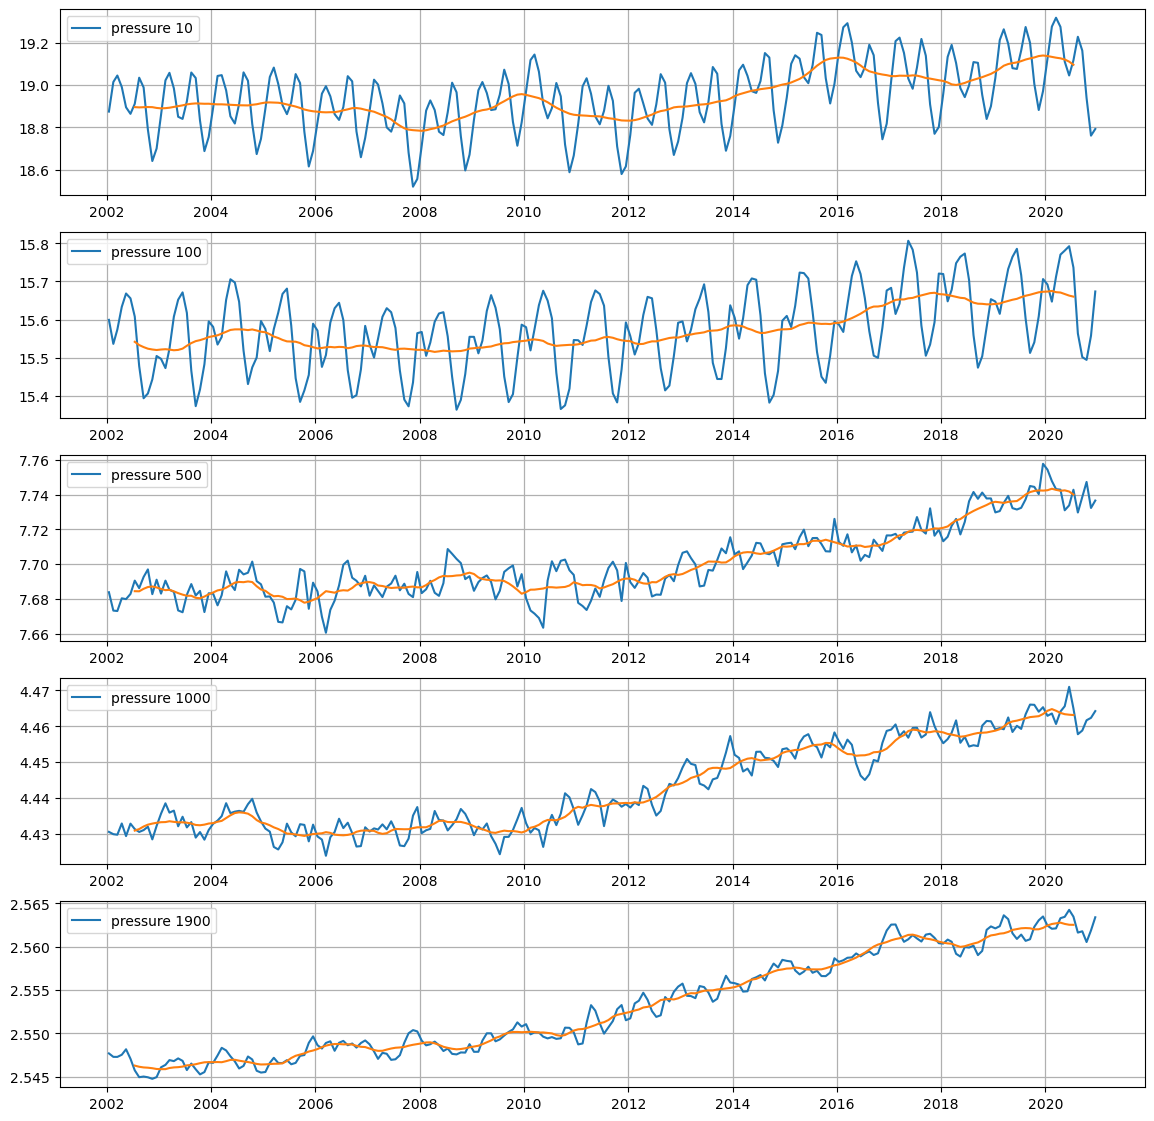

In [22]:
fig, ax = plt.subplots(5 , 1 , figsize = (14,14))
levels = ['10','100','500','1000','1900']
i1=0
for ipre in levels:
    ax[i1].plot(DC_temp_wmean.time,DC_temp_wmean.sel(depth=ipre,method="nearest"),label=('pressure ' + ipre ))
    ax[i1].plot(DC_temp_wmean.time,DC_temp_wmean_rolling.sel(depth=ipre,method="nearest"))
    ax[i1].grid(linestyle='-', linewidth=.9)
    #ax[i1].xaxis.set_tick_params(labelbottom=False)
    ax[i1].legend();
    i1=i1+1


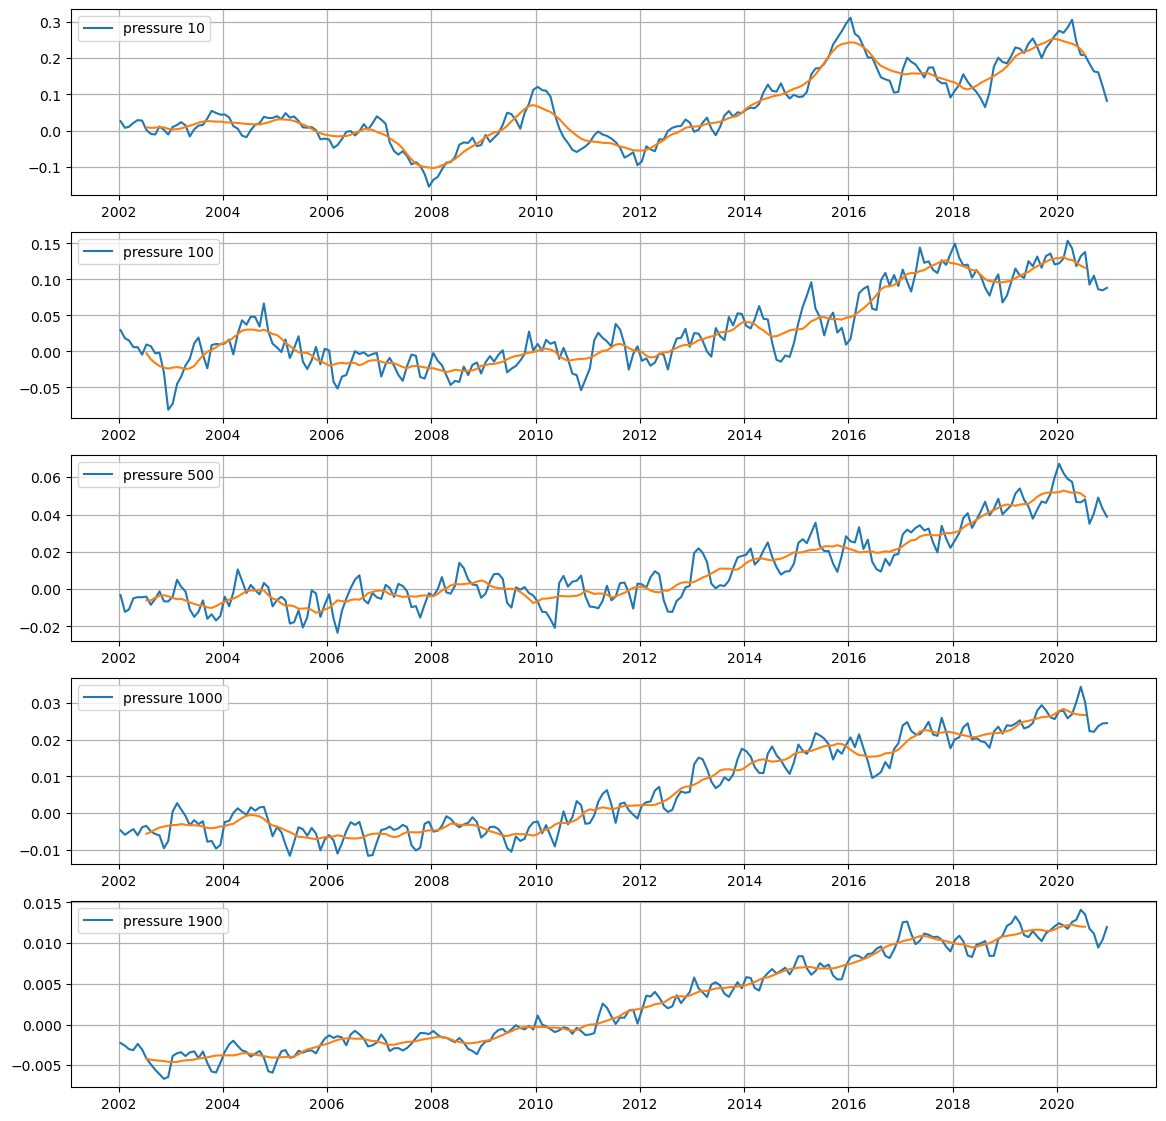

In [23]:
fig, ax = plt.subplots(5 , 1 , figsize = (14,14))
levels = ['10','100','500','1000','1900']
i1=0
for ipre in levels:
    ax[i1].plot(DC_temp_anom_wmean.time,DC_temp_anom_wmean.sel(depth=ipre,method="nearest"),label=('pressure ' + ipre ))
    ax[i1].plot(DC_temp_anom_wmean.time,DC_temp_anom_wmean_rolling.sel(depth=ipre,method="nearest"))
    ax[i1].grid(linestyle='-', linewidth=.9)
    ax[i1].legend();
    i1=i1+1

## Global mean

In [24]:
DC_temp_global_2000m=DC_temp_wmean.sel(depth=slice(0,2000)).mean("depth")
DC_temp_global_2000m.to_netcdf('./Data/ISAS20_temp_global_2000m.nc')

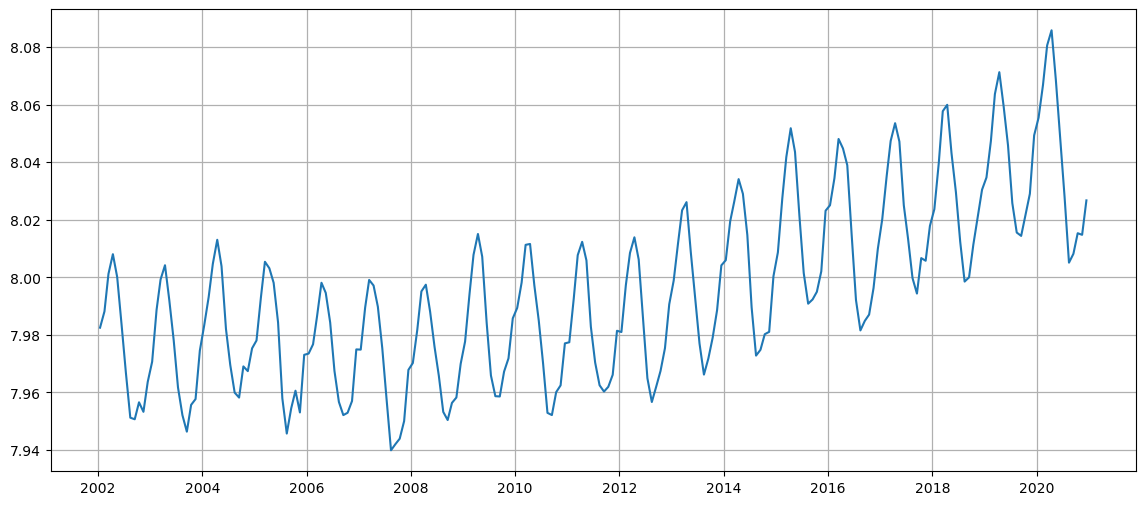

In [25]:
ig, ax = plt.subplots(figsize = (14,6))
ax.plot(DC_temp_global_2000m.time,DC_temp_global_2000m,)
ax.grid(linestyle='-', linewidth=.9)

In [26]:
DC_temp_anom_global_2000m=DC_temp_anom_wmean.sel(depth=slice(0,2000)).mean("depth")
DC_temp_anom_global_2000m.to_netcdf('./Data/ISAS20_temp_anom_global_2000m.nc')

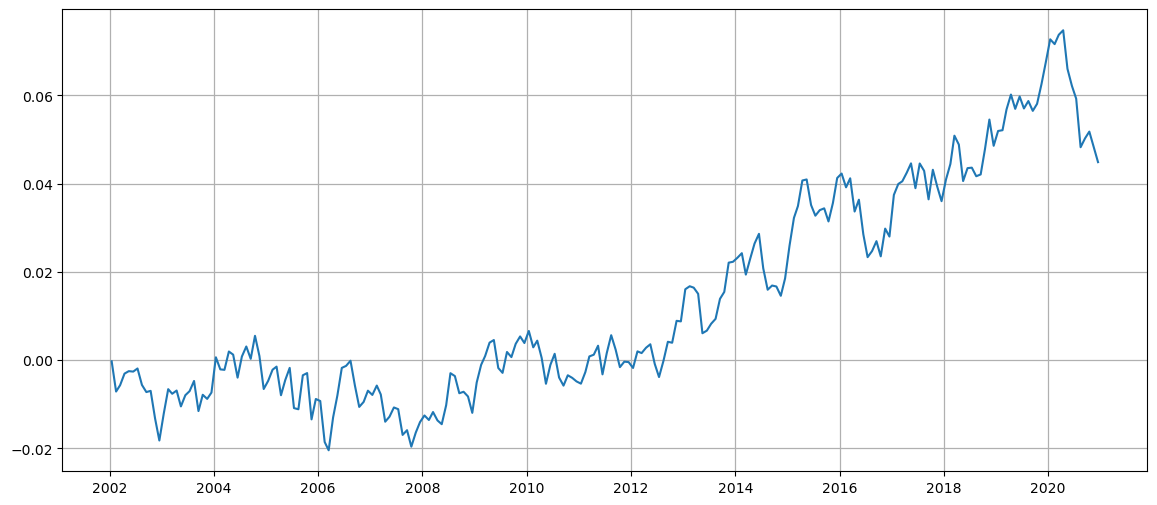

In [28]:
ig, ax = plt.subplots(figsize = (14,6))
ax.plot(DC_temp_anom_global_2000m.time,DC_temp_anom_global_2000m)
ax.grid(linestyle='-', linewidth=.9)